# Gan Monet project

This project has the goal to creat a Generative Adversarial Network (GAN) algorith that collect photos an transform them in to monet paintings. For that we will use the pytorch library to creat the generator and discriminator, that will convert the images, and them decided wich one is real and wich one was created by the computer. Gan is an unsupervised deep learning algorith.

In [1]:
import os
import cv2
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict
plt.style.use("ggplot")
import PIL
import tensorflow as tf
! mkdir ../images
from torchvision import datasets, transforms
from PIL import Image

2024-08-09 21:56:57.991594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 21:56:57.991716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 21:56:58.130413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List all physical devices
print("Physical devices:", tf.config.list_physical_devices())

Num GPUs Available:  2
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Uploading
We will started by uploading the data from the Kaggle dataset to our code, and transforming in to imagens, so we can visulize them.

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

monet_dataset = CustomImageDataset(image_folder='/kaggle/input/gan-getting-started/monet_jpg', transform=transform)
monetloader = DataLoader(monet_dataset, batch_size=32, shuffle=True)
photo_dataset =  CustomImageDataset(image_folder='/kaggle/input/gan-getting-started/photo_jpg', transform=transform)
photoloader = DataLoader(photo_dataset, batch_size=32, shuffle=True)

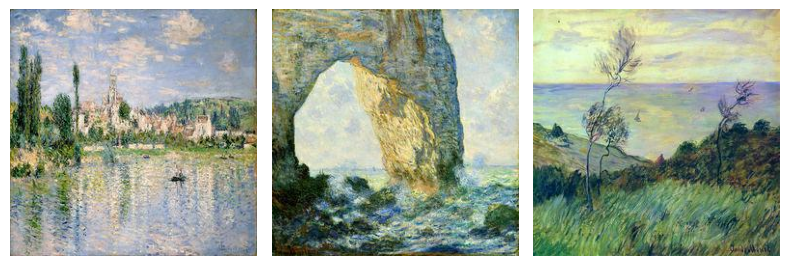

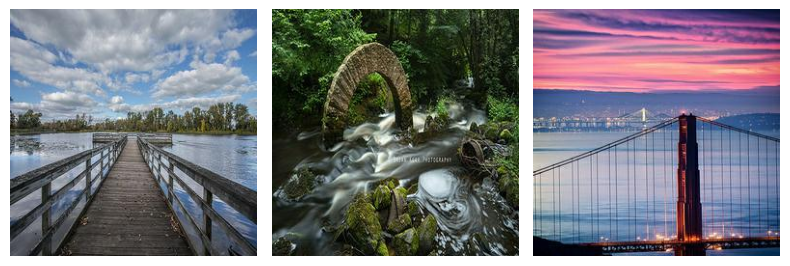

In [6]:
def plot_images(images):
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        img = (img * 0.5) + 0.5  # De-normalize to [0, 1]
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

for batch in monetloader:
    plot_images(batch)
    break
for batch in photoloader:
    plot_images(batch)
    break

We than observe the length of both datasets.

In [7]:
print(len(photo_dataset))
print(len(monet_dataset))

7038
300


## Blocks
We created 2 block algorith, one to dowsample(ex: imp[156, 256] to out[128, 128] and one to upsample. They will be later used for our genarator and discriminator.

In [8]:
class Downsample(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 norm=True):
        super().__init__()

        # --- Layers
        # Convolution Layer
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=2,  # Downsample by 2
                              padding=(kernel_size - 1) // 2,  # Same padding
                              bias=False)
        if norm:
            self.norm = nn.InstanceNorm2d(num_features=out_channels)
        else:
            self.norm = None

        # Activation layer
        self.act = nn.LeakyReLU()

    # --------------------------------------------------------------------------------
    def forward(self,
                x):
        out = self.conv(x)

        if self.norm:
            out = self.norm(out)

        out = self.act(out)

        return out
class Upsample(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=4,
                 dropout=True):

        super().__init__()

        # --- Layers
        # Transpose Convolution Layer
        self.conv = nn.ConvTranspose2d(in_channels=in_channels,
                                       out_channels=out_channels,
                                       kernel_size=kernel_size,
                                       stride=2,  # Upsample by 2
                                       padding=(kernel_size - 1) // 2,  # Same padding
                                       bias=False)

        # Normalisation layer (equivalent of GroupNorm where num_groups=out_channels
        self.norm = nn.InstanceNorm2d(num_features=out_channels)

        # Dropout
        if dropout:
            self.dropout = nn.Dropout(0.5)
        else:
            self.dropout = None

        # Activation layer
        self.act = nn.ReLU()

    # --------------------------------------------------------------------------------
    def forward(self,
                x):

        out = self.conv(x)
        out = self.norm(out)

        if self.dropout:
            out = self.dropout(out)

        out = self.act(out)

        return out

## Generator and discriminator.
We start our code by creating the generator that has a ConvTranspose2d base. The code downsample, for than upsample.

In [9]:
def conv_weight_init(m):
    if any(isinstance(m, _m) for _m in [nn.Conv2d, nn.ConvTranspose2d]):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [10]:
class Generator(nn.Module):

    # --------------------------------------------------------------------------------
    def __init__(self):
        super().__init__()

        # --- Encoder and Decoder
        self.encoder = self._init_encoder()
        self.decoder = self._init_decoder()

        # Final Upsample
        self.out = nn.ConvTranspose2d(in_channels=128,
                                      out_channels=3,
                                      kernel_size=4,
                                      stride=2, padding=1)

        # Maybe softsign could be better than TanH
        self.act = nn.Tanh()

        # Initialise conv wights with N(0, 0.02)
        self.apply(conv_weight_init)

    # --------------------------------------------------------------------------------
    def forward(self,
                x):

        # Encode to latent space / 128 #512
        skips = []  # Skip connections U-Net Style
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)

        # Skip last one, bottom bit, latent space
        skips = reversed(skips[:-1])

        # Decode form latent space *64 #128
        for layer, skip in zip(self.decoder, skips):
            x = layer(x)
            x = torch.cat((x, skip), dim=1)

        # Upsample so that out.shape == x.shape
        out = self.act(self.out(x))

        return out

    # --------------------------------------------------------------------------------
    def _init_encoder(self):

        # Settings
        kernel_size = 4
        in_channels = 64

        # Final layer will have 512 feature maps and it's final output size is x / 128
        out_channels = [128, 256, 512, 512, 512, 512]

        # First layer doesn't use norm so just add it now
        encoder = [Downsample(in_channels=3, out_channels=in_channels,
                              kernel_size=kernel_size, norm=False)]

        for out_ch in out_channels:
            # Add layer
            encoder.append(Downsample(in_channels=in_channels, out_channels=out_ch,
                                      kernel_size=kernel_size))

            # Update in_channels
            in_channels = out_ch

        return nn.Sequential(*encoder)

    # --------------------------------------------------------------------------------
    def _init_decoder(self):

        # Settings
        kernel_size = 4
        in_channels = [512, 1024, 1024, 1024, 512, 256]

        # Final layer will have the same number of channels as the output of first downsample from encoder
        out_channels = [512, 512, 512, 256, 128, 64]
        dropout = [True, True, True, False, False, False]

        decoder = [Upsample(in_channels=in_ch, out_channels=out_ch,
                            kernel_size=kernel_size, dropout=drop)

                   for in_ch, out_ch, drop in zip(in_channels, out_channels, dropout)]

        return nn.Sequential(*decoder)

For our discriminator, we will started by creating a history, so we can safe the imagens that have already been process. We than code the discriminator with the goal to differentiate the real monet paints from the ones created by the generator.

In [11]:
class DiscriminatorHistory:

    # --------------------------------------------------------------------------------
    def __init__(self,
                 buffer_size=50):

        self.buffer_size = buffer_size

        # Empty Tensor
        self.buffer = torch.Tensor()


    # --------------------------------------------------------------------------------
    def __call__(self,
                 x):

        # Make sure that the buffer is on the same device as x
        if self.buffer.device != x.device:
            self.buffer = self.buffer.to(x.device)

        # Check if buffer is filled
        if len(self.buffer) >= self.buffer_size:
            # Sample from the buffer
            sample_size = max(len(x) // 2, 1)
            history_indices = list(range(0, self.buffer_size))
            history_get_indices = random.sample(history_indices, k=sample_size)
            x1 = self.buffer[history_get_indices]

            if sample_size == 1:
                return x1

            # Sample from the input
            x_indices = list(range(0, len(x)))
            x_get_indices = random.sample(x_indices, k=sample_size)
            x_set_indices = list(set(x_indices) - set(x_get_indices))
            x2 = x[x_get_indices]

            # Replace buffer with other set of samples
            self.buffer[history_get_indices] = x[x_set_indices]

            # Concat
            x = torch.cat((x1, x2), 0)

        # Fill the buffer
        else:
            self.buffer = torch.cat((self.buffer, x), 0)

        # Return
        return x

In [12]:
class Discriminator(nn.Module):

    # --------------------------------------------------------------------------------
    def __init__(self):
        super().__init__()

        # --- Default settings
        base_channels = 64
        kernel_size = 4

        # --- History
        self.history = DiscriminatorHistory()

        # --- Discriminator network
        self.discriminator = nn.Sequential(
            Downsample(in_channels=3, out_channels=base_channels,
                       kernel_size=kernel_size, norm=False),
            Downsample(in_channels=base_channels, out_channels=base_channels * 2,
                       kernel_size=kernel_size),
            Downsample(in_channels=base_channels * 2, out_channels=base_channels * 4,
                       kernel_size=kernel_size),
            nn.ZeroPad2d(padding=(0, 2, 0, 2)),
            nn.Conv2d(in_channels=base_channels * 4, out_channels=base_channels * 8,
                      kernel_size=4, stride=1, bias=False),
            nn.InstanceNorm2d(num_features=base_channels * 8),
            nn.ZeroPad2d(padding=(0, 2, 0, 2)),
            nn.Conv2d(in_channels=base_channels * 8, out_channels=1,
                      kernel_size=4, stride=1),
            #             nn.Sigmoid()
        )

        # Initialise conv wights with N(0, 0.02)
        self.apply(conv_weight_init)

    # --------------------------------------------------------------------------------
    def forward(self,
                x,
                sample_history=False):

        # Update x based on history
        if sample_history:
            x = self.history(x)


        return self.discriminator(x)

## Gan
Now we will combine both algorith in order to produce our gan cycle. The Gan recive both the photos and the monet paintings and, it learn from the monet, and add layers of noise to the photos, in order to pass them for painting. The algorith then discriminate the fake and real imagens, in order to optimize the cycle and creat more precise monets. This code is base in 4  neural nets, 2 discriminators(fake photos, fake monets) and 2 generators(from monet to photo, from photo to monet).

In [13]:
class CycleGAN(nn.Module):
    
    # --------------------------------------------------------------------------------
    def __init__(self,
                 lr=2e-4,
                 lambda_cycle=10):  # Not sure what that is yet
        super().__init__()
        
        # Define Generators and Discriminators
        self.gen_monet = Generator()
        self.optim_gen_monet = optim.Adam(self.gen_monet.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        self.gen_photo = Generator()
        self.optim_gen_photo = optim.Adam(self.gen_photo.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        
        self.disc_monet = Discriminator()
        self.optim_disc_monet = optim.Adam(self.disc_monet.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        self.disc_photo = Discriminator()
        self.optim_disc_photo = optim.Adam(self.disc_photo.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        
        # Loss functions
        self.loss_l2 = nn.MSELoss()
        self.loss_l1 = nn.L1Loss()
        
        # Attribs
        self.lambda_cycle = lambda_cycle
    
    # --------------------------------------------------------------------------------
    def forward(self, x):
        return self.gen_monet(x)
    
    # --------------------------------------------------------------------------------
    def forward_apply_style(self,
                            real_A,
                            style="monet"):

        with torch.inference_mode(mode=True):
            self.eval()

            # Set networks and Domain
            if style == "monet":
                gen_A = self.gen_photo
                gen_B = self.gen_monet

                disc_A = self.disc_photo
                disc_B = self.disc_monet
            elif style == "photo":
                gen_A = self.gen_photo
                gen_B = self.gen_monet

                disc_A = self.disc_photo
                disc_B = self.disc_monet
            else:
                raise ValueError(f"Style can be either monet or photo, given: {style}")

            # ---
            # Forward, notation uses P=Photo and M=Monet to easier demonstrate the flow
            # x_P -> G_M -> \hat{x}_M
            fake_B = gen_B(real_A)

            # \hat{x}_M -> G_P -> \hat{x}_P
            cycled_A = gen_A(fake_B)

            # \hat{x}_M -> D_M -> \hat{y}_M
            disc_fake_B = disc_B(fake_B)

            # x_P -> D_P -> y_P
            disc_real_A = disc_A(real_A)

            # \hat{x}_P -> D_M -> \hat{y}_P
            disc_cycled_A = disc_A(cycled_A)

        return {"real_A" : real_A,
                "gen_fake_B" : fake_B,
                "gen_cycled_A" : cycled_A,
                "disc_fake_B" : disc_fake_B,
                "disc_real_A" : disc_real_A,
                "disc_cycled_A" : disc_cycled_A}

    # --------------------------------------------------------------------------------
    def forward_step(self, x):
        # Unpack data
        x_monet, x_photo = x
        
        # Zero Grad Optimisers
        self.optim_zero_grad()
        
        # --- Generate fake data
        x_fake_monet = self.gen_monet(x_photo)  # Real Photo -> Gm -> Fake Monet
        x_fake_photo = self.gen_photo(x_monet)  # Real Monet -> Gp -> Fake Photo
        
        # --- Discriminators
        # Monet
        d_real_monet = self.disc_monet(x_monet)  # How real does this real monet seems
        d_fake_monet = self.disc_monet(x_fake_monet.detach(), sample_history=True)  # How fake does this fake seems
        
        # Photo
        d_real_photo = self.disc_photo(x_photo)
        d_fake_photo = self.disc_photo(x_fake_photo.detach(), sample_history=True)
        
        # Discriminators Loss
        d_loss_monet = self.disc_loss(x_real=d_real_monet,
                                      x_fake=d_fake_monet)
        
        d_loss_photo = self.disc_loss(x_real=d_real_photo,
                                      x_fake=d_fake_photo)
        
        d_loss = d_loss_monet + d_loss_photo
        
        # Backward
        d_loss.backward()
        
        # Optimise
        self.optim_disc_monet.step()
        self.optim_disc_photo.step()
        
        # --- Generators
        # Adversarial
        x_adv_monet = self.disc_monet(x_fake_monet)  # How real does this fake monet seems
        x_adv_photo = self.disc_photo(x_fake_photo)  
        
        # Cycle
        x_cycled_monet = self.gen_monet(x_fake_photo)  # Fake Photo -> Gm -> Cycled Monet
        x_cycled_photo = self.gen_photo(x_fake_monet)  # Fake Monet -> Gp -> Cycled Photo
        
        # Adversarial Loss
        g_loss_adv_monet = self.loss_l2(torch.ones_like(x_adv_monet), x_adv_monet)
        g_loss_adv_photo = self.loss_l2(torch.ones_like(x_adv_photo), x_adv_photo)
        
        # Cycle Loss
        g_loss_cycle_monet = self.loss_l1(x_monet, x_cycled_monet) * self.lambda_cycle
        g_loss_cycle_photo = self.loss_l1(x_photo, x_cycled_photo) * self.lambda_cycle
        
        # Identity Loss
#         g_loss_idt_monet = self.loss_l1(x_monet, x_fake_monet) * self.lambda_cycle
#         g_loss_idt_photo = self.loss_l1(x_photo, x_fake_photo) * self.lambda_cycle
        
        # Total Loss
        g_loss_monet = g_loss_adv_monet + g_loss_cycle_monet #+ g_loss_idt_monet
        g_loss_photo = g_loss_adv_photo + g_loss_cycle_photo #+ g_loss_idt_photo
        g_loss = g_loss_monet + g_loss_photo
        
        # Backward
        g_loss.backward()
        
        # Optimise
        self.optim_gen_monet.step()
        self.optim_gen_photo.step()
        
        # Get Losses
        return {
            "g_monet" : g_loss_monet,
            "g_photo" : g_loss_photo,
            "d_monet" : d_loss_monet,
            "d_photo" : d_loss_photo
        }
    
    # --------------------------------------------------------------------------------
    def disc_loss(self,
                  x_real,
                  x_fake):
        
        loss_real = self.loss_l2(torch.ones_like(x_real), x_real)
        loss_fake = self.loss_l2(torch.zeros_like(x_fake), x_fake)
        
        return (loss_real + loss_fake) * 0.5
    
    # --------------------------------------------------------------------------------
    def optim_zero_grad(self):
        # Generators
        self.optim_gen_monet.zero_grad()
        self.optim_gen_photo.zero_grad()
        
        # Discriminators
        self.optim_disc_monet.zero_grad()
        self.optim_disc_photo.zero_grad()

In [14]:
cycle_gan = CycleGAN()
x_real = torch.ones(1, 3, 256, 256)
x_fake = torch.zeros_like(x_real)
cycle_gan.forward_step((x_real, x_fake))

{'g_monet': tensor(10.3390, grad_fn=<AddBackward0>),
 'g_photo': tensor(21.0046, grad_fn=<AddBackward0>),
 'd_monet': tensor(2.7662, grad_fn=<MulBackward0>),
 'd_photo': tensor(2.2232, grad_fn=<MulBackward0>)}

In [15]:
class MonetDataset(Dataset):
    def __init__(self, 
                 root_path):
        
        # Paths
        self.root_path = root_path
        self.photo_paths = os.listdir(f"{root_path}/photo_jpg")
        self.monet_paths = os.listdir(f"{root_path}/monet_jpg")
        
    def __len__(self):
        return len(self.photo_paths)
    
    def __getitem__(self, idx):
        """ Get one of the photos and a random monet
        """
        
        # Get a photo path
        path_photo = f"{root_path}/photo_jpg/{self.photo_paths[idx]}"
        
        # Get a random monet path
        path_monet = f"{root_path}/monet_jpg/{random.choices(self.monet_paths, k=1)[0]}"
        
        # Load imgs and transform
        x_photo = self.to_tensor(self.read_img(path_photo))
        x_monet = self.to_tensor(self.read_img(path_monet))
        
        return x_monet, x_photo
        
    def to_tensor(self, x):
        """ Transform uint8 image [0,255] to torch float32 [-1,1]
        """
        return torch.tensor(x, dtype=torch.float32).permute(2,0,1) / 127.5 - 1.0
        
    def read_img(self, path):
        """ Read img with cv2 and transform to RGB
        """
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)   

We will now run the cicly with 15 epochs, and using the kaggle data. We will than add the imagens to a fold and submited to evaluation.

In [16]:
root_path = '/kaggle/input/gan-getting-started'
# Training params
NUM_EPOCHS = 15
BATCH_SIZE = 16

# Keep losses per epoch
loss_epoch = defaultdict(list)

# Dataset and data loader
dataset = MonetDataset(root_path=root_path)
data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

# Model
cycle_gan = CycleGAN(lr=2e-4,).to(device)

In [17]:
for i in range(1, NUM_EPOCHS + 1):  # Starting at one for tqdm
    
    # Tqdm
    with tqdm(total=len(data_loader),
          desc=f"Epoch {i}/{NUM_EPOCHS}",
          ascii=True, 
          colour="green") as pbar:
        
        # Per batch
        loss_batch = defaultdict(list)
        for x in data_loader:
            x_monet = x[0].to(device)
            x_photo = x[1].to(device)

            # Batch of data
            loss = cycle_gan.forward_step((x_monet, x_photo))

            # Update dict
            for k, v in loss.items():
                loss_batch[k].append(v.item())

            # Bar Update
            pbar.set_postfix({k:v.item() for k, v in loss.items()})
            pbar.update()
            
        # Update mean loss for epoch
        for k, v in loss_batch.items():
            loss_epoch[k].append(np.mean(v))

Epoch 1/15:   0%|          | 0/440 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/15: 100%|##########| 440/440 [13:43<00:00,  1.86s/it, g_monet=2.51, g_photo=2.2, d_monet=0.272, d_photo=0.237] /opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 15/15: 100%|##########| 440/440 [13:44<00:00,  1.87s/it, g_monet=0.855, g_photo=0.767, d_monet=0.206, d_photo=0.241]


In [18]:
i = 1
data_loader = DataLoader(dataset=dataset, batch_size=1)
with torch.inference_mode(mode=True):
    cycle_gan.eval()
    
    for x in data_loader:
        photo, _ = x
        
        pred = cycle_gan(photo.to(device)).cpu().squeeze().numpy()
        pred = np.transpose(pred, (1,2,0))
        
        pred = (pred * 127.5 + 127.5).astype(np.uint8)
        
        pred_img = PIL.Image.fromarray(pred)
        pred_img.save("../images/" + str(i) + ".jpg")
        
        i += 1

In [19]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## References
https://www.kaggle.com/code/ruchi798/getting-started-with-gans
https://github.com/junyanz/CycleGAN
https://www.tensorflow.org/tutorials/generative/dcgan
https://keras.io/examples/
https://www.kaggle.com/code/paradoxplusparadise/cyclegan